In [37]:
import numpy as np
import pandas as pd
import datetime
from scipy import signal
import math

import matplotlib.pyplot as plt

# read, extract, resampled, sliced

In [38]:
def standardize_sensor_raw_info(path_csv_sensor, data_col_names):
    
    sensor_df = pd.read_csv(path_csv_sensor, names=data_col_names)
    unix_time = sensor_df.iloc[0,0]
    
    sampling_frequency = sensor_df.iloc[1,0]
    
    sensor_df_sliced = sensor_df.iloc[2 :, :]
    
    sensor_df_sliced_copy = sensor_df_sliced.copy()
    
    sensor_df_sliced_copy = sensor_df_sliced_copy.reset_index(drop=True)
    
    sampling_time = 1/sampling_frequency
    
    timestamps = unix_time + (sensor_df_sliced_copy.index)*sampling_time
    
    sensor_df_sliced_copy['timestamps'] = timestamps
    
    sensor_df_sliced_copy['starting_timestamp'] = ''
    
    sensor_df_sliced_copy['starting_timestamp'] = [unix_time]+['']*(len(sensor_df_sliced_copy)-1)
    
    end_time = timestamps[-1]
    sensor_df_sliced_copy['ending_timestamp'] = ''
    sensor_df_sliced_copy['ending_timestamp'] = [end_time]+['']*(len(sensor_df_sliced_copy)-1)
    
    
    sensor_df_sliced_copy['sampling_frequency'] = ''
    
    sensor_df_sliced_copy['sampling_frequency'] =[sampling_frequency]+['']*(len(sensor_df_sliced_copy)-1)
    
    return sensor_df_sliced_copy
    
    

In [39]:
def resample_sensor_data(original_standardize_df,  sensor_cols, new_sampling_frequency):
    
    
    orignal_sampling_frequecy = original_standardize_df["sampling_frequency"][0]
    
    multiplier = new_sampling_frequency/orignal_sampling_frequecy
    
    total_new_samples = multiplier * len(original_standardize_df)
    
    new_df = pd.DataFrame()
    
    
    for sensor_col in sensor_cols:
        
        #print(sensor_col)
        
        signal_array=original_standardize_df[sensor_col].values
        
        signal_array_resampled = signal.resample(signal_array, int(total_new_samples))
        
        
        new_df[sensor_col] = signal_array_resampled
        
        
    new_sampling_time = 1/new_sampling_frequency
    
    starting_time = original_standardize_df["starting_timestamp"][0]
    
    timestamps = starting_time + (new_df.index)*new_sampling_time
    
    
    
    new_df['timestamps'] = timestamps
    
    
    new_df['starting_timestamp'] = ''
    new_df['starting_timestamp'] = [starting_time]+['']*(len(new_df)-1)
    
    end_time = timestamps[-1]
    new_df['ending_timestamp'] = ''
    new_df['ending_timestamp'] = [end_time]+['']*(len(new_df)-1)
    
    new_df['sampling_frequency'] = ''
    new_df['sampling_frequency'] =[new_sampling_frequency]+['']*(len(new_df)-1)
    
    
    return new_df
        

In [40]:
def magnitude_acc_sensor(std_acc_df):    
    magnitude= np.sqrt(std_acc_df.iloc[:,0]**2 + std_acc_df.iloc[:,1]**2 + std_acc_df.iloc[:,2]**2)
    std_acc_df['magnitude'] = magnitude
    return std_acc_df

In [41]:
def normalize_signal (std_df, signal_col):
    
    signal = std_df[signal_col]
    
    mean_signal = np.mean(signal)
    
    mean_sub = signal - mean_signal
    
    scaled_data =  mean_sub/np.max(np.abs(mean_sub))
    
    std_df["mean_norm"] = scaled_data
    
    return std_df
    


In [42]:
def get_start_stop_timestamps(list_dfs):
    
    starting_time_list = [df["starting_timestamp"][0] for df in list_dfs]
    ending_time_list  = [df["ending_timestamp"][0] for df in list_dfs]
    
    late_start = max(starting_time_list)
    early_stop =min(ending_time_list)
    
    return late_start, early_stop

In [43]:
def align_slice_df(df, start_time, stop_time):
    
    sliced_df=df[(df.timestamps>=start_time)&(df.timestamps <= stop_time)]
    
    sliced_df =sliced_df.copy()
    
    return sliced_df

# Testing on the data 

### Accelorometer data

In [8]:
#acc_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/ACC.csv"
acc_sensor_path = "C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/ACC.csv"
data_col_names = ['x', 'y', 'z']

In [9]:
acc_df_stand=standardize_sensor_raw_info (acc_sensor_path, data_col_names)
acc_df_stand = magnitude_acc_sensor(acc_df_stand)
acc_df_stand_norm = normalize_signal(acc_df_stand, 'magnitude')

## Heart rate data

In [11]:
#hr_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/HR.csv"
hr_sensor_path = "C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/HR.csv"
data_col_names = ['signal']

In [12]:
hr_df_stand=standardize_sensor_raw_info(hr_sensor_path, data_col_names)
hr_df_stand_resamp = resample_sensor_data(hr_df_stand,  ["signal"], 32)
hr_df_stand_resamp_norm = normalize_signal (hr_df_stand_resamp, "signal")

### Eda Data

In [13]:
#eda_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/EDA.csv"
eda_sensor_path = "C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/EDA.csv"
data_col_names = ['signal']

In [14]:
eda_df_stand=standardize_sensor_raw_info(eda_sensor_path, data_col_names)
eda_df_resamp_stand = resample_sensor_data(eda_df_stand,  ["signal"], 32)
eda_df_stand_resamp_norm = normalize_signal (eda_df_resamp_stand, "signal")

## Alligning and slicing data of all the sensors 

In [15]:
list_dfs = [acc_df_stand_norm, hr_df_stand_resamp_norm, eda_df_stand_resamp_norm]

In [16]:
start_time, stop_time = get_start_stop_timestamps(list_dfs)    

In [17]:
acc_df_sliced_synced= align_slice_df(acc_df_stand_norm, start_time, stop_time)

In [18]:
eda_df_sliced_synced = align_slice_df(eda_df_stand_resamp_norm, start_time, stop_time)

In [19]:
hr_df_sliced_synced= align_slice_df(hr_df_stand_resamp_norm, start_time, stop_time)

In [20]:
hr_df_sliced_synced.shape 

(124096, 6)

In [21]:
eda_df_sliced_synced.shape

(124096, 6)

In [22]:
eda_df_sliced_synced

,signal,timestamps,starting_timestamp,ending_timestamp,sampling_frequency,mean_norm
320,0.055091,1.695387e+09,,,,-0.322092
321,0.042985,1.695387e+09,,,,-0.323655
322,0.032790,1.695387e+09,,,,-0.324971
323,0.026044,1.695387e+09,,,,-0.325841
324,0.023751,1.695387e+09,,,,-0.326138
...,...,...,...,...,...,...
124411,5.314990,1.695391e+09,,,,0.356929
124412,4.121475,1.695391e+09,,,,0.202854
124413,2.929519,1.695391e+09,,,,0.048979
124414,1.806666,1.695391e+09,,,,-0.095974


In [23]:
acc_df_sliced_synced.shape

(124096, 9)

In [24]:
acc_df_sliced_synced

,x,y,z,timestamps,starting_timestamp,ending_timestamp,sampling_frequency,magnitude,mean_norm
320,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
321,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
322,25.0,-7.0,57.0,1.695387e+09,,,,62.633857,-0.002078
323,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
324,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
...,...,...,...,...,...,...,...,...,...
124411,11.0,12.0,61.0,1.695391e+09,,,,63.134776,0.003927
124412,12.0,12.0,61.0,1.695391e+09,,,,63.316664,0.006107
124413,13.0,14.0,61.0,1.695391e+09,,,,63.921827,0.013362
124414,10.0,14.0,60.0,1.695391e+09,,,,62.417946,-0.004667


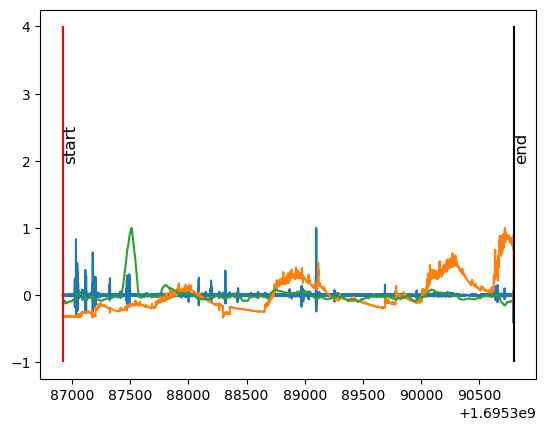

In [25]:
fsz = 26
fsz_fig= 32
fig, ax = plt.subplots()

##---------------------------------------------

ax.plot(acc_df_sliced_synced["timestamps"], acc_df_sliced_synced["mean_norm"])
ax.plot(eda_df_sliced_synced["timestamps"], eda_df_sliced_synced["mean_norm"])
ax.plot(hr_df_sliced_synced["timestamps"],hr_df_sliced_synced["mean_norm"])

ax.vlines(acc_df_sliced_synced["timestamps"].values[0], ymin=-1, ymax=4, color = 'red')
ax.text(x= acc_df_sliced_synced["timestamps"].values[0], y= 2, s="start", rotation = 90, fontsize = 12)

ax.vlines(acc_df_sliced_synced["timestamps"].values[-1], ymin=-1, ymax=4, color = 'black')
ax.text(x= acc_df_sliced_synced["timestamps"].values[-1], y= 2, s="end", rotation = 90, fontsize = 12)

plt.show()

## Behavioral Data

In [189]:
#psychopy_csv_path = "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/psychopy/237035_DigiRelax_Experiment_2023-10-17_16h09.10.215.csv"
psychopy_csv_path = "C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/datasets/psychopy/237035_DigiRelax_Experiment_2023-10-17_16h09.10.215.csv"

In [195]:
psychopy_df = pd.read_csv(psychopy_csv_path, sep='\t', low_memory=False

,"Reference_time,baseline_instruction_ts,baseline_ts,sam_e_rt,sam_e_ts,mouse_e.x,mouse_e.y,mouse_e.leftButton,mouse_e.midButton,mouse_e.rightButton,mouse_e.clicked_name,SAM_Number,sam_a_rt,sam_a_ts,mouse_a.x,mouse_a.y,mouse_a.leftButton,mouse_a.midButton,mouse_a.rightButton,mouse_a.clicked_name,selected_sam_a,saliva_probe_2_ts,change_room_ts,tsst_prep_ts,tsst_pres_ts,tsst_arithmetic_ts,tsst_end_ts,saliva_probe_3_ts,relaxation_instruction_ts,relaxation_ts,saliva_probe_4_ts,final_instruction_ts,participant,session,date,expName,psychopyVersion,frameRate,"
0,"1697551753.963336,1697551759.512417,1697551759..."
1,",,,,,,,,,,,2,10.359292832989013,1697551765.512..."
2,",,,40.65872833400499,1697551795.637574,0.19238..."
3,",,,,,,,,,,,3,41.59985566599062,1697551796.7531..."
4,",,,65.33384658399154,1697551820.3126771,0.1923..."
5,",,,,,,,,,,,4,65.98589491599705,1697551821.1391..."
6,",,,,,,,,,,,,,,,,,,,,a4,,,,,,,,,,1697551826.718..."


,index,"Reference_time,baseline_instruction_ts,baseline_ts,sam_e_rt,sam_e_ts,mouse_e.x,mouse_e.y,mouse_e.leftButton,mouse_e.midButton,mouse_e.rightButton,mouse_e.clicked_name,SAM_Number,sam_a_rt,sam_a_ts,mouse_a.x,mouse_a.y,mouse_a.leftButton,mouse_a.midButton,mouse_a.rightButton,mouse_a.clicked_name,selected_sam_a,saliva_probe_2_ts,change_room_ts,tsst_prep_ts,tsst_pres_ts,tsst_arithmetic_ts,tsst_end_ts,saliva_probe_3_ts,relaxation_instruction_ts,relaxation_ts,saliva_probe_4_ts,final_instruction_ts,participant,session,date,expName,psychopyVersion,frameRate,"
0,0,"1697551753.963336,1697551759.512417,1697551759..."
1,1,",,,,,,,,,,,2,10.359292832989013,1697551765.512..."
2,2,",,,40.65872833400499,1697551795.637574,0.19238..."
3,3,",,,,,,,,,,,3,41.59985566599062,1697551796.7531..."
4,4,",,,65.33384658399154,1697551820.3126771,0.1923..."
5,5,",,,,,,,,,,,4,65.98589491599705,1697551821.1391..."
6,6,",,,,,,,,,,,,,,,,,,,,a4,,,,,,,,,,1697551826.718..."


In [180]:
shimmer_path="D:/Datasets/sony_digirelax/schimmer/VP001_251023_Session1_Shimmer_8108_Calibrated_SD.csv"

In [181]:
#shimmer_df =pd.read_csv(shimmer_path, sep='\t',skiprows=(0),header=(0), low_memory=False)

In [182]:
shimmer_df =pd.read_csv(shimmer_path, sep = "t",  skiprows=(0), low_memory=False)

In [185]:
shimmer_sam_path = "D:/Datasets/sony_digirelax/sam_data/shimmer/WP1_01_AJTY_Session1_Shimmer_CF2E_Calibrated_SD.csv"

In [186]:
shimmer_sam_df =pd.read_csv(shimmer_sam_path)

In [187]:
shimmer_sam_df

,sep=\t
0,Shimmer_CF2E_Timestamp_Unix_CAL\tShimmer_CF2E_...
1,ms\tm/(s^2)\tm/(s^2)\tm/(s^2)\tno_units\tuS\tk...
2,1.6915742933120117E12\t6.619565217391304\t4.19...
3,1.6915742933198242E12\t6.619565217391304\t4.17...
4,1.6915742933237305E12\t6.608695652173913\t4.18...
...,...
614171,1.6915766929174805E12\t5.989130434782608\t4.82...
614172,1.6915766929213867E12\t6.021739130434782\t4.81...
614173,1.691576692925293E12\t6.0\t4.793478260869565\t...
614174,1.6915766929291992E12\t6.0\t4.793478260869565\...


In [ ]:
#shimmer_df = pd.read_table(shimmer_path)

Index(['Reference_time', 'sam_e_rt', 'sam_e_ts', 'mouse_e.x', 'mouse_e.y',
       'mouse_e.leftButton', 'mouse_e.midButton', 'mouse_e.rightButton',
       'sam_a_rt', 'sam_a_ts', 'mouse_a.x', 'mouse_a.y', 'mouse_a.leftButton',
       'mouse_a.midButton', 'mouse_a.rightButton', 'stress_slider.started',
       'stress_slider.response', 'saliva_probe_1_ts', 'change_room_ts',
       'tsst_prep_ts', 'tsst_end_ts', 'tsst_end_exp_ts', 'saliva_probe_2_ts',
       'saliva_probe_3_ts', 'key_resp_3.started', 'key_resp_3.keys',
       'key_resp_3.rt', 'saliva_probe_4_ts', 'final_instruction_ts',
       'participant', 'session', 'date', 'expName', 'psychopyVersion',
       'frameRate', 'Unnamed: 35'],
      dtype='object')